In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd

plt.style.use('seaborn-white')

## Comparing Results of MOOG against Literature Values from exoplanets.org

In [2]:
# Read in Exoplanet Database csv
exo_df = pd.read_csv("pydata/exoplanet_database.csv", skiprows=[1])
print(list(exo_df.columns))
print(exo_df[['STAR', "RA", "DEC"]][exo_df["LOGG"] < 3])

['STAR', 'COMP', 'ORBREF', 'ORBURL', 'RA', 'FIRSTREF', 'FIRSTURL', 'DEC', 'MSTAR', 'MSTARUPPER', 'MSTARLOWER', 'UMSTAR', 'RSTAR', 'RSTARUPPER', 'RSTARLOWER', 'URSTAR', 'DIST', 'DISTUPPER', 'DISTLOWER', 'UDIST', 'TEFF', 'TEFFUPPER', 'TEFFLOWER', 'UTEFF', 'LOGG', 'LOGGUPPER', 'LOGGLOWER', 'ULOGG', 'FE', 'FEUPPER', 'FELOWER', 'UFE']
                STAR         RA        DEC
156         HD 32518   5.160172  69.639556
219        HD 102329  11.779631   3.474339
268        HD 208527  21.939995  21.239822
286        HD 100655  11.584386  20.441547
368          HD 1690   0.353700  -8.281164
385      gamma Leo A  10.332823  19.841861
412           42 Dra  18.433052  65.563547
441         HD 13189   2.161159  32.316422
480        alpha Ari   2.119524  23.462778
511   TYC 1422-614-1  10.285187  19.558333
661            8 UMi  14.946756  74.900914
670        HD 216536  22.884437  44.477500
831         HD 11977   1.915560 -67.647481
888           14 And  23.521444  39.236403
910           81 Cet   

In [3]:
# Collect list of stellar parameter files
stellar_param_files = glob.glob("pydata/sumout_files/*")

In [4]:
# Generate Stellar Parameter DataFrame
stellar_param_dict = {}
files = ["pydata/sumout_files/11Com_2012.m.sumout"]
for file in stellar_param_files:
    with open(file,'r') as f:
        for i, line in enumerate(f):
            if i == 0:
                star = f.readline().split(" ")[0].split("_")[0] # fix this for ngc
                #print(star)
                params = [elem for elem in f.readline().split(" ") if elem != '']
                #print(params)
                metallicity = params[-2]
                if '-' in metallicity:
                    metallicity = metallicity[4:]
                file_dict = {'Teff': float(params[2]), 'Log_g':float(params[6]), 'M/H':float(metallicity)}
                #print(file_dict)
                stellar_param_dict[star] = file_dict
                
param_df = pd.DataFrame.from_dict(stellar_param_dict, orient='index')

In [12]:
# Cross Reference the two Dataframes, generate a comparison Dataframe

cross_ref_dict = {}
for row in param_df.iterrows():
    teff = row[1]["Teff"]
    logg = row[1]["Log_g"]
    metal = row[1]["M/H"]
    #teff, logg, metal = row[1][:]
    if 'ngc' in row[0]:
        continue
    exo_df_subset = [s for s in list(exo_df['STAR']) if row[0].lower() in s.replace(' ','').lower()]
    if len(exo_df_subset)== 0:
        #print(row[0])
        continue
    #print(row[0])
    exo_match = exo_df[exo_df['STAR'] == exo_df_subset[0]]
    exo_match = exo_match.head(1) # If there's multiple planets multiple matchs will happen, just take the first one

    delta_teff = teff - float(exo_match['TEFF']) #don't do absolute differences
    delta_logg = logg - float(exo_match['LOGG'])
    delta_metal = metal - float(exo_match['FE'])
    match_dict = {'DELTATEFF': delta_teff, 'DELTALOGG':delta_logg, 'DELTAFE':delta_metal,
                 'UTEFF': float(exo_match['UTEFF']), 'ULOGG': float(exo_match['ULOGG']), 'UFE': float(exo_match['UFE']),
                 'OURLOGG':logg, 'EXOLOGG': float(exo_match['LOGG'])}
    cross_ref_dict[row[0]] = match_dict

cross_ref_df = pd.DataFrame.from_dict(cross_ref_dict, orient='index')
print(cross_ref_df.to_csv('for_iceland/our_params_vs_exodotorg.csv'))

None


Fraction of TEFF Measurements within UTEFF: 0.8611111111111112
Fraction of LOGG Measurements within ULOGG: 0.8055555555555556
Fraction of FE Measurements within UFE: 0.6388888888888888


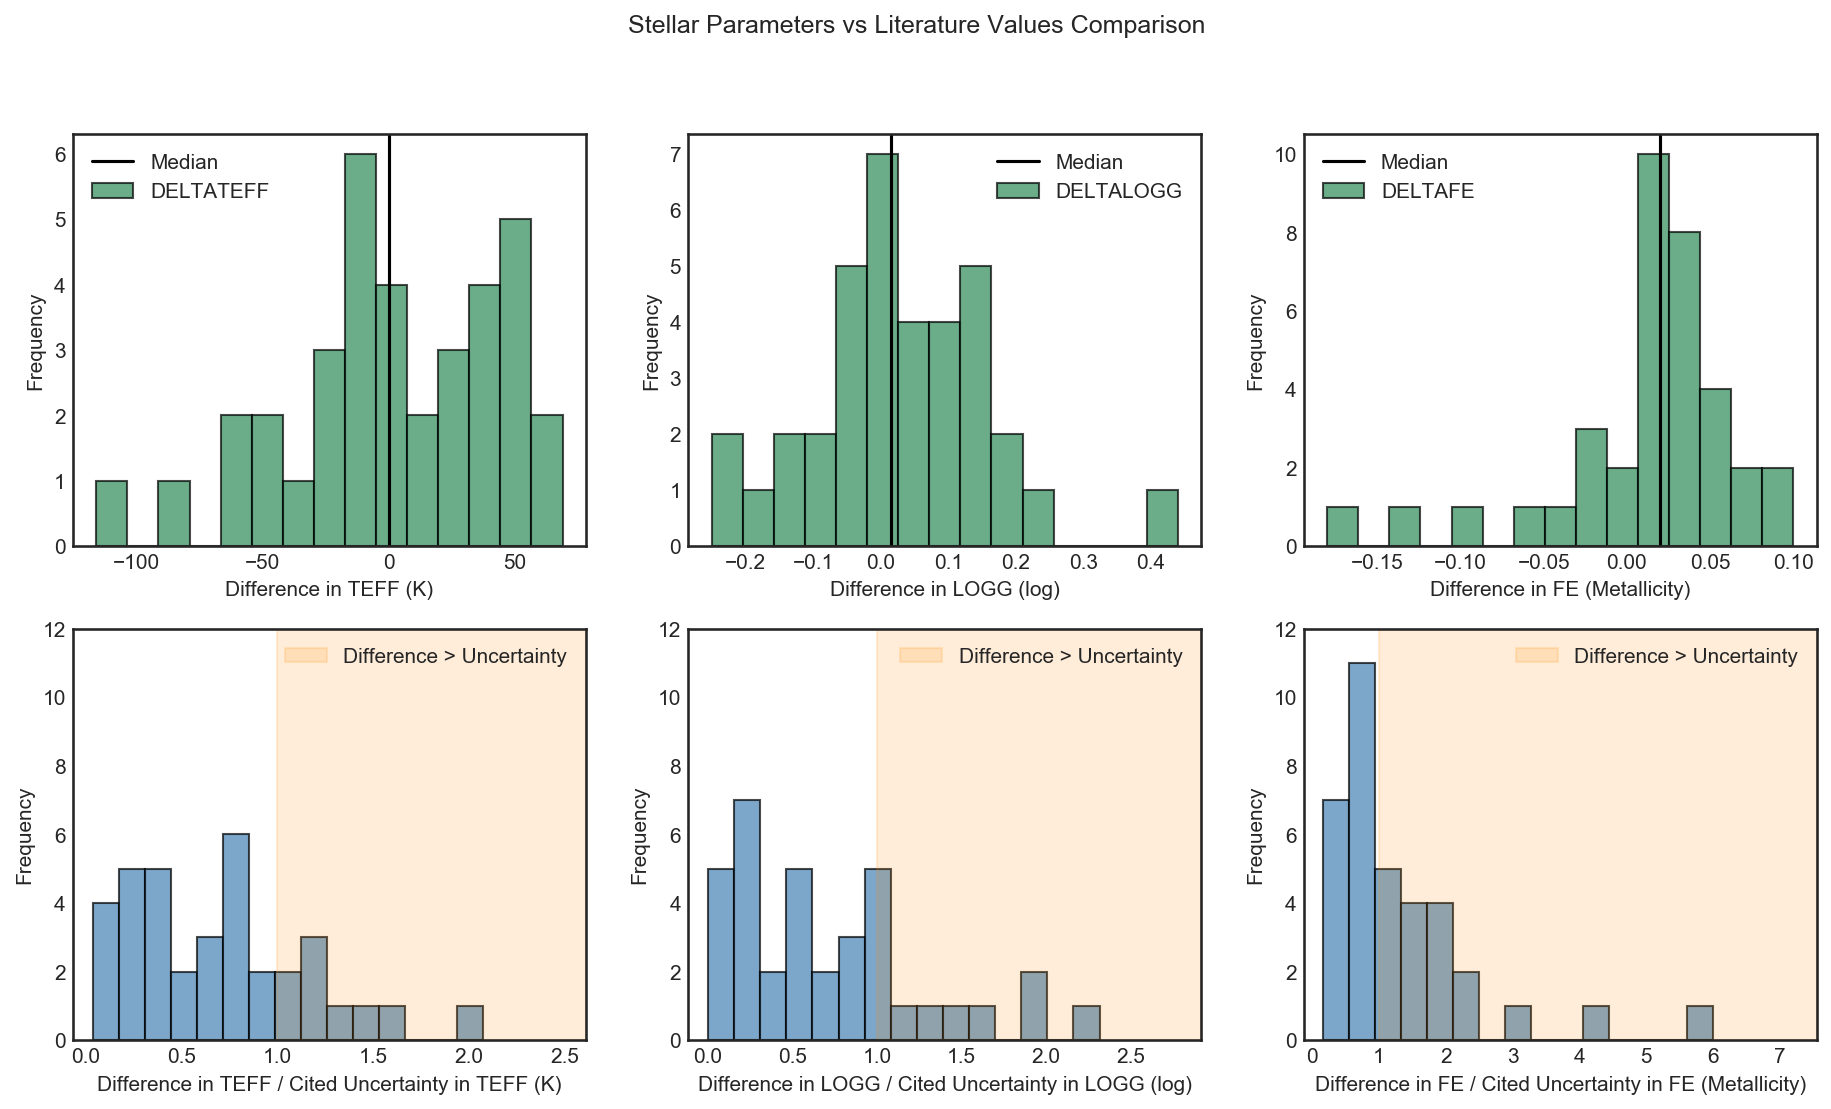

In [6]:
fig, axes = plt.subplots(2,3, figsize=(15,8), dpi = 150)
quantities = ['DELTATEFF', 'DELTALOGG', 'DELTAFE']
uncertainties = ['UTEFF', 'ULOGG', 'UFE']
units = ['K', 'log', 'Metallicity']
for idx,ax in enumerate(axes[0]):
    #ax.set_xlim(-125,125)
    ax.hist(cross_ref_df[quantities[idx]], histtype='bar',ec='black', color = 'seagreen', alpha = 0.7, bins = 15)
    ax.set_xlabel("Difference in {} ({})".format(quantities[idx][5:], units[idx]))
    ax.set_ylabel("Frequency")
    #ax.set_ylim([0,12])
    ax.axvline(np.median(cross_ref_df[quantities[idx]]), color='k', label = 'Median')
    ax.legend()
    
for idx,ax in enumerate(axes[1]):
    ax.set_xlabel("Difference in {} / Cited Uncertainty in {} ({})".format(quantities[idx][5:],quantities[idx][5:], units[idx]))
    ax.hist(abs(cross_ref_df[quantities[idx]]) / cross_ref_df[uncertainties[idx]], histtype='bar',ec='black', color='steelblue', alpha=0.7, bins=15)
    ax.set_ylabel("Frequency")
    #ax.axvline(0, color='k')
    left, right = ax.get_xlim()
    ax.set_ylim([0,12])
    ax.axvspan(1, 1.2*right, alpha=0.15, color='darkorange', label="Difference > Uncertainty")
    ax.set_xlim([left,1.2*right])
    #ax.text(right/10,0.7*top, "Diff > Unc")
    ax.legend()
    
fig.suptitle("Stellar Parameters vs Literature Values Comparison")
#plt.tight_layout()
plt.savefig("plots/literature_comparison.png")
print("Fraction of TEFF Measurements within UTEFF: {}".format(np.sum((cross_ref_df['DELTATEFF']-cross_ref_df['UTEFF']) <= 0)/ len(list(cross_ref_df['DELTATEFF']))))
print("Fraction of LOGG Measurements within ULOGG: {}".format(np.sum((cross_ref_df['DELTALOGG']-cross_ref_df['ULOGG']) <= 0)/ len(list(cross_ref_df['DELTALOGG']))))
print("Fraction of FE Measurements within UFE: {}".format(np.sum((cross_ref_df['DELTAFE']-cross_ref_df['UFE']) <= 0)/ len(list(cross_ref_df['DELTAFE']))))

In [20]:
print(len(cross_ref_df))
cross_ref_df[['DELTATEFF','UTEFF','DELTALOGG','ULOGG','DELTAFE','UFE']]

36


,DELTATEFF,UTEFF,DELTALOGG,ULOGG,DELTAFE,UFE
11Com,-20.0,79.0,-0.10,0.13,0.06,0.06
18Del,-16.0,38.0,0.01,0.10,0.02,0.03
24Sex,-49.0,62.0,0.00,0.13,0.01,0.05
7CMa,29.0,79.0,0.10,0.22,-0.02,0.05
81Cet,55.0,51.0,0.44,0.19,0.10,0.04
AlphaAri,47.0,72.0,-0.03,0.21,0.02,0.03
GammaLeoA,2.0,53.0,-0.16,0.17,0.04,0.03
HD100655,49.0,60.0,-0.03,0.18,0.07,0.04
HD102272,-17.0,34.0,-0.03,0.13,0.02,0.03
HD102329,35.0,71.0,0.05,0.16,0.03,0.04


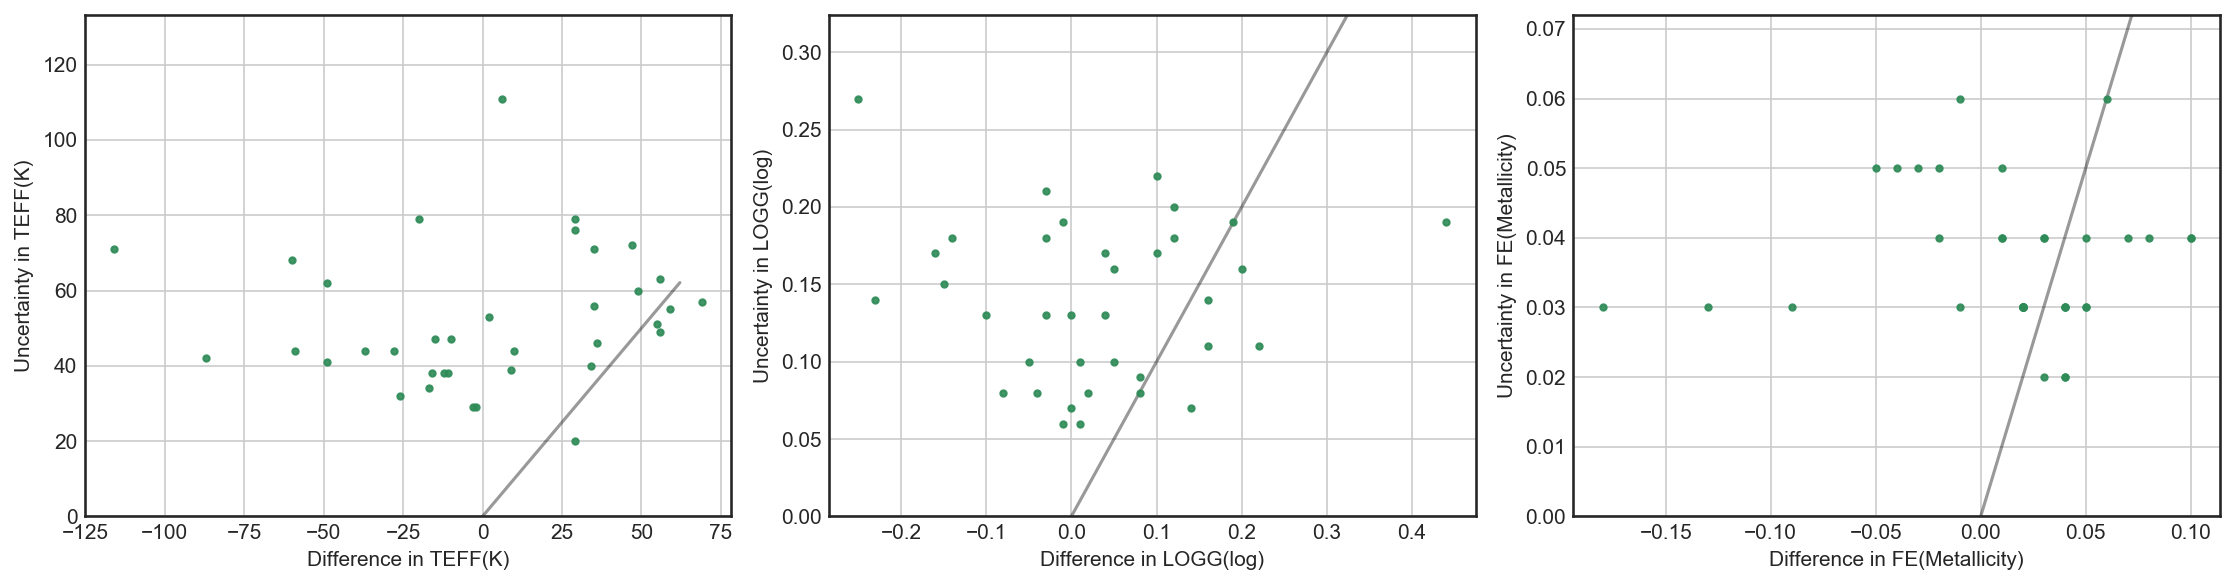

In [79]:
fig, axes = plt.subplots(1,3, figsize=(15,4), dpi = 150)
quantities = ['DELTATEFF', 'DELTALOGG', 'DELTAFE']
uncertainties = ['UTEFF', 'ULOGG', 'UFE']
units = ['K', 'log', 'Metallicity']
for idx,ax in enumerate(axes):
    #print(quantities[idx])
    x = np.arange(np.max(cross_ref_df[quantities[idx]]), step= np.max(cross_ref_df[quantities[idx]])/10)
    #print(x)
    ax.plot(x,x,color='k',alpha=0.4)
    ax.plot(cross_ref_df[quantities[idx]], cross_ref_df[uncertainties[idx]], '.', color = 'seagreen', alpha = 0.9)
    ax.set_xlabel("Difference in {}({})".format(quantities[idx][5:], units[idx]))
    ax.set_ylabel("Uncertainty in {}({})".format(quantities[idx][5:], units[idx]))
    ax.grid()
    ax.set_ylim(0,1.2*np.max(cross_ref_df[uncertainties[idx]]))
plt.tight_layout()

In [7]:
cross_ref_df

,DELTATEFF,DELTALOGG,DELTAFE,UTEFF,ULOGG,UFE
11Com,-20.0,-0.10,0.06,79.0,0.13,0.06
18Del,-16.0,0.01,0.02,38.0,0.10,0.03
24Sex,-49.0,0.00,0.01,62.0,0.13,0.05
7CMa,29.0,0.10,-0.02,79.0,0.22,0.05
81Cet,55.0,0.44,0.10,51.0,0.19,0.04
AlphaAri,47.0,-0.03,0.02,72.0,0.21,0.03
GammaLeoA,2.0,-0.16,0.04,53.0,0.17,0.03
HD100655,49.0,-0.03,0.07,60.0,0.18,0.04
HD102272,-17.0,-0.03,0.02,34.0,0.13,0.03
HD102329,35.0,0.05,0.03,71.0,0.16,0.04
